<a href="https://colab.research.google.com/github/jeanbai/Human-Protein-Cell-Classification/blob/main/Human_Protein_Cell_Data_Augmentation_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Libraries

In [1]:
import math, re, os
import numpy as np
import tensorflow as tf

print("Tensorflow version " + tf.__version__)

Tensorflow version 2.4.1


In [2]:
import math, re, os
import numpy as np
import tensorflow as tf


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense,Dropout,BatchNormalization,Conv2D,MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image

In [5]:

import pandas as pd
import matplotlib.pyplot as plt

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
from tqdm import tqdm

Import label dataset

In [8]:
data = pd.read_csv("/content/drive/MyDrive/train.csv")

In [9]:
data.head()

,ID,Label
0,5c27f04c-bb99-11e8-b2b9-ac1f6b6435d0,8|5|0
1,5fb643ee-bb99-11e8-b2b9-ac1f6b6435d0,14|0
2,60b57878-bb99-11e8-b2b9-ac1f6b6435d0,6|1
3,5c1a898e-bb99-11e8-b2b9-ac1f6b6435d0,16|10
4,5b931256-bb99-11e8-b2b9-ac1f6b6435d0,14|0


In [10]:
label_names = {
    '0': "Nucleoplasm",
    '1': "Nuclear membrane",
    '2': "Nucleoli",
    '3': "Nucleoli fibrillar center",
    '4': "Nuclear speckles",
    '5': "Nuclear bodies",
    '6': "Endoplasmic reticulum",
    '7': "Golgi apparatus",
    '8': "Intermediate filaments",
    '9': "Actin filaments",
    '10': "Microtubules",
    '11': "Mitotic spindle",
    '12': "Centrosome",
    '13': "Plasma membrane",
    '14': "Mitochondria",
    '15': "Aggresome",
    '16': "Cytosol",
    '17': "Vesicles and punctate cytosolic patterns",
    '18': "Negative",
}

Apply Hot_Encode for multi_label categories

In [11]:
train = data.copy()
lab_idx = label_names.keys()

train['Label'] = train['Label'].map(lambda x: x.split('|'))

for label in lab_idx:
    train[label_names[label]] = train['Label'].map(lambda result: 1 if label in result else 0)

In [12]:
train.head()

,ID,Label,Nucleoplasm,Nuclear membrane,Nucleoli,Nucleoli fibrillar center,Nuclear speckles,Nuclear bodies,Endoplasmic reticulum,Golgi apparatus,Intermediate filaments,Actin filaments,Microtubules,Mitotic spindle,Centrosome,Plasma membrane,Mitochondria,Aggresome,Cytosol,Vesicles and punctate cytosolic patterns,Negative
0,5c27f04c-bb99-11e8-b2b9-ac1f6b6435d0,"[8, 5, 0]",1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
1,5fb643ee-bb99-11e8-b2b9-ac1f6b6435d0,"[14, 0]",1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,60b57878-bb99-11e8-b2b9-ac1f6b6435d0,"[6, 1]",0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,5c1a898e-bb99-11e8-b2b9-ac1f6b6435d0,"[16, 10]",0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
4,5b931256-bb99-11e8-b2b9-ac1f6b6435d0,"[14, 0]",1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [13]:
train.shape

(21806, 21)

Import image file

In [14]:
img_width = 150
img_height = 150

X = []

for i in tqdm(range(train.shape[0])):
    path = '/content/drive/MyDrive/rgb/' + train['ID'][i] + '.png'
    img = image.load_img(path, target_size=(img_width, img_height, 3))
    img = image.img_to_array(img)
    img = img/255.0
    X.append(img)

X = np.array(X)


100%|██████████| 21806/21806 [03:29<00:00, 103.89it/s]


In [15]:
X.shape

(21806, 150, 150, 3)

In [16]:
y = train.drop(['ID',"Label"],axis = 1)
y = y.to_numpy()
y.shape

(21806, 19)

In [17]:
X_train, X_test,y_train,y_test = train_test_split(X, y,random_state = 0, test_size = 0.30)

In [18]:
X_train.shape

(15264, 150, 150, 3)

In [19]:
X_test.shape

(6542, 150, 150, 3)

In [20]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# create a data generator
datagen = ImageDataGenerator(
        #samplewise_center=True,  # set each sample mean to 0
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True) # we don't e

Model Creation

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Conv2D,
    MaxPool2D,
    Flatten,
    Dropout,
    BatchNormalization,
)

model = Sequential()
model.add(Conv2D(75, (3, 3), strides=1, padding="same", activation="relu", 
                 input_shape=(150, 150, 3)))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Conv2D(50, (3, 3), strides=1, padding="same", activation="relu"))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Conv2D(25, (3, 3), strides=1, padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Flatten())
model.add(Dense(units=512, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(units=19, activation="sigmoid"))

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 75)      2100      
_________________________________________________________________
batch_normalization (BatchNo (None, 150, 150, 75)      300       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 75)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 50)        33800     
_________________________________________________________________
dropout (Dropout)            (None, 75, 75, 50)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 75, 75, 50)        200       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 38, 38, 50)        0

Use ImageDataGenerator to solve imbalanced class problem.

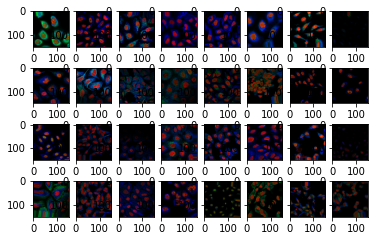

In [23]:
import matplotlib.pyplot as plt
import numpy as np
batch_size = 32
img_iter = datagen.flow(X_train, y_train, batch_size=batch_size)

x, y = img_iter.next()
fig, ax = plt.subplots(nrows=4, ncols=8)
for i in range(batch_size):
    image = x[i]
    ax.flatten()[i].imshow(np.squeeze(image))
plt.show()

In [24]:
datagen.fit(X_train)

In [25]:
model.compile(optimizer="adam", loss = 'binary_crossentropy', metrics=['accuracy'])

In [ ]:


#model.fit(img_iter,
          epochs=20,
          steps_per_epoch=len(X_train)/batch_size, # Run same number of steps we would if we were not using a generator.
          validation_data=(X_test, y_test))

Epoch 1/20
477/477 [==============================] - 276s 576ms/step - loss: 0.3665 - accuracy: 0.2835 - val_loss: 0.2701 - val_accuracy: 0.3323
Epoch 2/20
477/477 [==============================] - 279s 584ms/step - loss: 0.2401 - accuracy: 0.3827 - val_loss: 0.2361 - val_accuracy: 0.4168
Epoch 3/20
477/477 [==============================] - 276s 579ms/step - loss: 0.2317 - accuracy: 0.3897 - val_loss: 0.2237 - val_accuracy: 0.4395
Epoch 4/20
477/477 [==============================] - 278s 582ms/step - loss: 0.2233 - accuracy: 0.4222 - val_loss: 0.2363 - val_accuracy: 0.4066
Epoch 5/20
477/477 [==============================] - 277s 580ms/step - loss: 0.2177 - accuracy: 0.4392 - val_loss: 0.3983 - val_accuracy: 0.3092
Epoch 6/20
477/477 [==============================] - 275s 576ms/step - loss: 0.2123 - accuracy: 0.4440 - val_loss: 0.2094 - val_accuracy: 0.4781
Epoch 7/20
477/477 [==============================] - 276s 579ms/step - loss: 0.2102 - accuracy: 0.4461 - val_loss: 0.2107 -

In [26]:
history = model.fit(X_train,y_train,epochs=20,validation_data=(X_test,y_test))

Epoch 1/20
477/477 [==============================] - 265s 554ms/step - loss: 0.3706 - accuracy: 0.2727 - val_loss: 0.3246 - val_accuracy: 0.2819
Epoch 2/20
477/477 [==============================] - 272s 570ms/step - loss: 0.2320 - accuracy: 0.3849 - val_loss: 0.2240 - val_accuracy: 0.3980
Epoch 3/20
477/477 [==============================] - 270s 566ms/step - loss: 0.2181 - accuracy: 0.4329 - val_loss: 0.2209 - val_accuracy: 0.4141
Epoch 4/20
477/477 [==============================] - 270s 566ms/step - loss: 0.2010 - accuracy: 0.4714 - val_loss: 0.2224 - val_accuracy: 0.4401
Epoch 5/20
477/477 [==============================] - 269s 565ms/step - loss: 0.1833 - accuracy: 0.5030 - val_loss: 0.2251 - val_accuracy: 0.4239
Epoch 6/20
477/477 [==============================] - 269s 564ms/step - loss: 0.1584 - accuracy: 0.5605 - val_loss: 0.2302 - val_accuracy: 0.4132
Epoch 7/20
477/477 [==============================] - 265s 556ms/step - loss: 0.1374 - accuracy: 0.6109 - val_loss: 0.2414 -

In [28]:
def plot_learningCurve(history,epoch):
    epoch_range = range(1, epoch+1)
    plt.plot(epoch_range, history.history['accuracy'])
    plt.plot(epoch_range,history.history['val_accuracy'])
    plt.title("Model Accuracy")
    plt.ylabel('accuracy')
    plt.xlabel("Epoch")
    plt.legend(["Train",'Val'], loc='upper left')
    plt.show()

    plt.plot(epoch_range, history.history['loss'])
    plt.plot(epoch_range,history.history['val_loss'])
    plt.title("Model Loss")
    plt.ylabel('Loss')
    plt.xlabel("Epoch")
    plt.legend(["Train",'Val'], loc='upper left')
    plt.show()